louding libraries

In [2]:
import torch
import torchvision 
import tarfile
from torch.utils.data import DataLoader , random_split
import os


In [3]:
!wget "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

--2023-01-22 17:54:15--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.79.206, 52.216.205.213, 52.216.20.19, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.79.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 128.85M  54.4MB/s    in 2.4s    

2023-01-22 17:54:18 (54.4 MB/s) - ‘cifar10.tgz’ saved [135107811/135107811]



In [4]:
with tarfile.open("/content/cifar10.tgz", "r:gz") as tar:
  tar.extractall("./data")

exploring the data

In [5]:
from ast import walk
?os.walk

In [6]:
for path,dir,file in os.walk("./data"):
  print(f"there is {len(dir)} dir and {len(file)} file in {path}")

there is 1 dir and 0 file in ./data
there is 2 dir and 0 file in ./data/cifar10
there is 10 dir and 0 file in ./data/cifar10/test
there is 0 dir and 1000 file in ./data/cifar10/test/dog
there is 0 dir and 1000 file in ./data/cifar10/test/cat
there is 0 dir and 1000 file in ./data/cifar10/test/frog
there is 0 dir and 1000 file in ./data/cifar10/test/bird
there is 0 dir and 1000 file in ./data/cifar10/test/truck
there is 0 dir and 1000 file in ./data/cifar10/test/horse
there is 0 dir and 1000 file in ./data/cifar10/test/deer
there is 0 dir and 1000 file in ./data/cifar10/test/ship
there is 0 dir and 1000 file in ./data/cifar10/test/automobile
there is 0 dir and 1000 file in ./data/cifar10/test/airplane
there is 10 dir and 0 file in ./data/cifar10/train
there is 0 dir and 5000 file in ./data/cifar10/train/dog
there is 0 dir and 5000 file in ./data/cifar10/train/cat
there is 0 dir and 5000 file in ./data/cifar10/train/frog
there is 0 dir and 5000 file in ./data/cifar10/train/bird
there is 

loadeing data

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
from torchvision.datasets.fakedata import transforms
train = ImageFolder("./data/cifar10/train",transform=ToTensor())
test = ImageFolder("./data/cifar10/test",transform=ToTensor())

In [9]:
img,label = train[0]
print("image shape", img.shape)
print(label)

image shape torch.Size([3, 32, 32])
0


In [10]:
class_names = train.classes

In [11]:
size = len(train)
train,valid = random_split(train, [int(0.8*size),int(0.2*size)] )

batching with dataloader

In [12]:
train_dl , valid_dl = DataLoader(train, 32,True),DataLoader(valid, 32,True)

visualise

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots( figsize=(20,20))
    
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images,5).permute(1,2,0))
    break

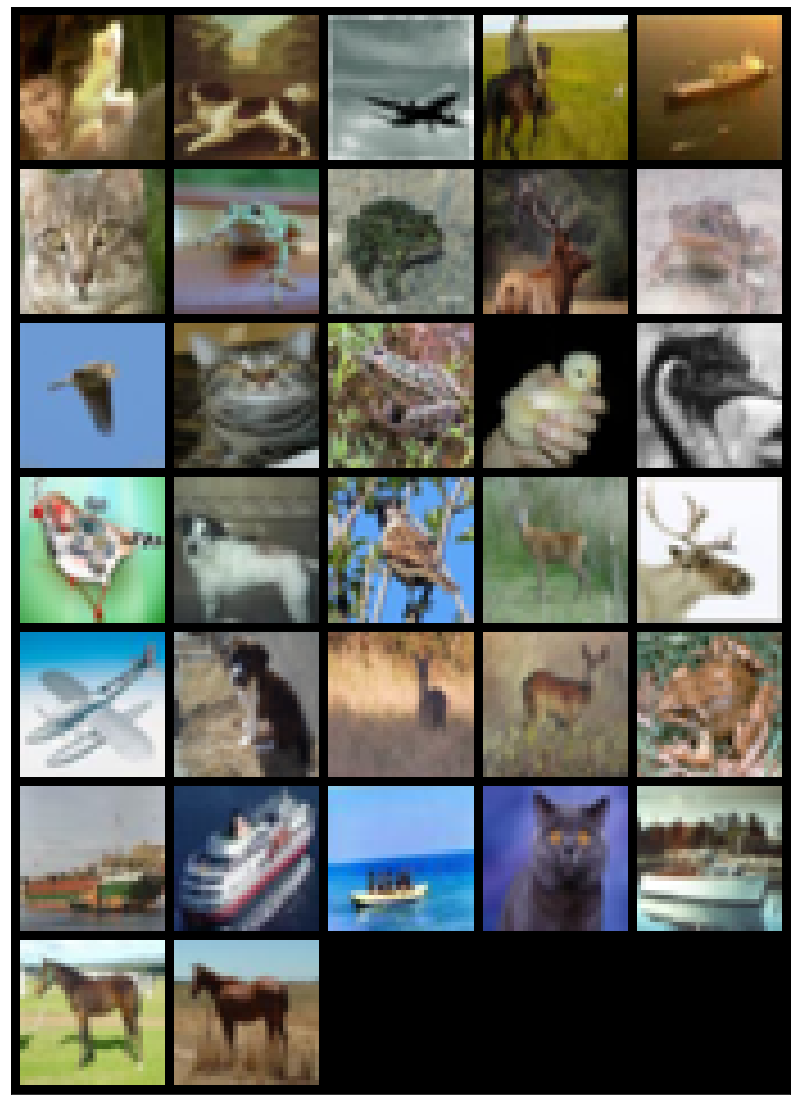

In [14]:
show_batch(train_dl)

### create a model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
model = nn.Sequential(
    
    nn.Conv2d(3,16,3,1,1),
    #nn.MaxPool2d(3,1)
)

In [17]:
for xb,yb in train_dl:
  out = model(xb)
  break

In [18]:
xb[0].shape

torch.Size([3, 32, 32])

In [19]:
out.shape

torch.Size([32, 16, 32, 32])

In [36]:
from torch.nn.modules import linear
model = nn.Sequential(
    
    nn.Conv2d(3,16,3,1,1),
    nn.ReLU(),
    nn.Conv2d(16,32,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32,64,1,1),
    nn.ReLU(),
    nn.Conv2d(64,128,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(128,256,3,1,1),
    nn.ReLU(),
    nn.Conv2d(256,256,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(256*4*4,10)

)

In [37]:
for xb,yb in train_dl:
  out = model(xb)
  break
out.shape
torch.sum(F.softmax(out), dim=1)

<ipython-input-37-e2e77ea2e3cc>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.sum(F.softmax(out), dim=1)


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

create an image classifier

In [ ]:
opt = torch.optim.Adam(model.parameters(), 0.05)

In [24]:
def accuracy(l1,l2):
  return (l1==l2).sum()/l1.numel()

In [27]:
accuracy(torch.tensor([1,2,3]), torch.tensor([2,3,3]))

tensor(0.3333)

In [50]:
class ImageClassifier(nn.Module):
  def training_step(self,batch):
    img , labels = batch
    out = model(img)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss
  
  def val_batch(self,batch_val):
    img,labels = batch
    out = model(img)
    loss = F.cross_entropy(out,labels)
    preds = F.softmax(out)
    acc = accuracy(torch.argmax(preds), labels)
    return {"loss":loss,"acc":acc}

  def val_epoch(self,result):
    losses = [x["loss"] for x in result ]
    epoch_loss = torch.stack(losses).mean()
    accs  = [x["acc"] for x in result ]
    epoch_acc = torch.stack(accs).mean()
    return epoch_loss , epoch_acc





In [33]:
class cifar10(ImageClassifier):
  def __init__(self) :
    super().__init__()

    self.network = nn.Sequential(
    
    nn.Conv2d(3,16,3,1,1),
    nn.ReLU(),
    nn.Conv2d(16,32,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32,64,1,1),
    nn.ReLU(),
    nn.Conv2d(64,128,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(128,256,3,1,1),
    nn.ReLU(),
    nn.Conv2d(256,256,3,1,1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(256*4*4,10)

    )

  def forward(self, xb):
   return self.network(xb)


In [54]:
model = cifar10()

In [55]:
model.train()

cifar10(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [52]:
model = ImageClassifier()

In [59]:
for batch in train_dl:
    img , labels = batch
    out = model(img)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    opt.step()
    opt.zero_grad()

    print(loss.item())

  

2.304569959640503
2.3025407791137695
2.3038330078125
2.3013103008270264
2.3034608364105225
2.304863452911377
2.3053879737854004
2.3018810749053955
2.303602457046509
2.302278995513916
2.2989213466644287
2.3015103340148926
2.3040690422058105
2.30330491065979
2.3010027408599854
2.3053407669067383
2.301823616027832
2.30391788482666
2.302952527999878
2.304474353790283
2.3031277656555176
2.304597854614258
2.301640510559082
2.302006721496582
2.3050129413604736
2.3024587631225586
2.303590774536133
2.304107666015625
2.304286479949951
2.299513339996338
2.301137924194336
2.3032822608947754
2.3026204109191895
2.3023624420166016
2.304678440093994
2.3043484687805176
2.3023147583007812
2.302295207977295
2.2998945713043213
2.301820993423462
2.3036553859710693
2.3040823936462402
2.302656888961792
2.304678201675415
2.3031117916107178
2.3010611534118652
2.3035130500793457
2.303684711456299
2.3036789894104004
2.3005127906799316
2.3029556274414062
2.301739454269409
2.3043341636657715
2.300260543823242
2.30

KeyboardInterrupt: ignored